In [1]:
from pathlib import Path
import random
import re
import pycountry
from collections import Counter
from tqdm.notebook import tqdm
from tabulate import tabulate
from dateutil import parser
from datetime import datetime
from omnibelt import load_json, save_json

In [2]:
def parse_date(date: str, time: str):
	# date = parser.parse(date)
	# time = parser.parse(time)
	date = datetime.strptime(date, '%y-%m-%d')
	time = datetime.strptime(time, '%H-%M-%S')
	return datetime(date.year, date.month, date.day, time.hour, time.minute)

def get_ident(art):
	return f'{art["title"]!r},{art["publishedAt"]!r}'
	return (art['title'], art['publishedAt'])
	return art['url']
	return (art['title'], art['publishedAt'], art['url'])

In [3]:
root = Path('/home/fleeb/workspace/local_data/nnn')
recs = (root/'raw_news').glob('**/*.json')
recs = list(recs)
len(recs)

152506

In [197]:
codes = set(p.stem.split('_')[1] for p in root.glob('**/general_*.json'))
len(codes)

54

In [198]:
all_categories = {'general', 'business', 'entertainment', 'health', 'science', 'sports', 'technology'}
def load_fixed(p: Path):
	*rest, scrape_date, scrape_time, _ = p.parts
	scraped = parse_date(scrape_date, scrape_time).strftime('%Y-%m-%dT%H:%M:%SZ')
	cat, loc = p.stem.split('_')
	if cat not in all_categories:
		if loc not in all_categories:
			raise ValueError(f'Unknown category {cat} {loc}')
		cat, loc = loc, cat
	content = load_json(p)
	# itr.set_description(f'{len(content["articles"])} {cat}-{loc}')
	for a in content['articles']:
		a.update({'location': loc, 'category': cat, 'collectedAt': scraped})
	return content['articles']

In [6]:
all_articles = []

In [7]:
for p in tqdm(sorted(recs)):
	*_, scrape_date, scrape_time, _ = p.parts
	if scrape_date.startswith('bad'):
		continue
	all_articles.extend(load_fixed(p))
len(all_articles)

  0%|          | 0/152506 [00:00<?, ?it/s]

7419387

In [32]:
unique = {}
for a in tqdm(all_articles):
	unique.setdefault(get_ident(a), []).append(a)
len(unique)

  0%|          | 0/7419387 [00:00<?, ?it/s]

4719199

In [33]:
nums = Counter({k: len(v) for k, v in unique.items()})
len(nums)

4719199

In [34]:
keys, most = zip(*nums.most_common(10))
most
# print(tabulate([[*k[:-1], v] for k,v in nums.most_common(10)], headers=['Title', 'Published', 'Count']))

(586, 507, 476, 424, 408, 386, 384, 381, 371, 345)

In [35]:
def article_difference(a, b):
	return {k: (a[k], b[k]) for k in a if a[k] != b[k]}

In [36]:
most_ident, most_count = nums.most_common(1)[0]

In [37]:
iv = unique[most_ident]
len(iv)

586

In [38]:
diffs = [article_difference(a, iv[0]) for a in iv[1:]]

In [42]:
unique_locs = {}
for ident, arts in tqdm(unique.items()):
	locs = set(a['location'] for a in arts)
	if len(locs) == 1:
		unique_locs.setdefault(locs.pop(), []).append(ident)
uloc_nums = {code: len(v) for code, v in unique_locs.items()}

  0%|          | 0/4719199 [00:00<?, ?it/s]

In [44]:
locset = {}
for ident, arts in tqdm(unique.items()):
	locs = set(a['location'] for a in arts)
	locset.setdefault(tuple(sorted(locs)), []).append(ident)
len(locset)

  0%|          | 0/4719199 [00:00<?, ?it/s]

5109

In [47]:
plu = max(locset, key=lambda x: len(x))
plu

('au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za')

In [49]:
sample = random.choice(locset[plu])
sample

"Modern Human Ancestry Won't Be Traced to a Single Point - Ancient Origins, 2021-02-13T17:50:00Z"

In [50]:
arts = unique[sample]
len(arts)

17

In [51]:
diffs = [article_difference(a, arts[0]) for a in arts[1:]]

In [62]:
fixed = {}
bad = []
bad_keys = {'title', 'author', 'publishedAt', 'url', 'description', 'content', 'urlToImage'}
itr = tqdm(unique.items())
for ident, arts in itr:
	itr.set_description(f'bad={len(bad)}')
	assert ident not in fixed, str(ident)
	if len(arts) > 1:
		bad_overlap = set(x for a in arts[1:] for xs in article_difference(a, arts[0]) for x in xs if x in bad_keys)
		if bad_overlap:
			bad.append(ident)
			continue
	instances = set((a['collectedAt'], a['location'], a['category']) for a in arts)
	# if len(instances) != len(arts):
	# 	bad.append(ident)
	# 	continue
	info = arts[0].copy()
	# info['category'] = list(sorted(set(a['category'] for a in arts)))
	info['instances'] = [{'collectedAt': col, 'location': loc, 'category': cat} for col, loc, cat in sorted(instances)]
	if info['publishedAt'] == '1970-01-01T00:00:00Z':
		info['publishedAt'] = None
	info['source-id'] = info['source']['id']
	info['source-name'] = info['source']['name']
	del info['category'], info['location'], info['collectedAt'], info['source']
	fixed[ident] = info

len(fixed), len(bad)

  0%|          | 0/4719199 [00:00<?, ?it/s]

(4719199, 0)

In [67]:
collecteds = [inst['collectedAt'] for a in fixed.values() for inst in a['instances']]
min(collecteds), max(collecteds)

('2020-08-07T18:53:00Z', '2021-11-29T09:46:00Z')

In [70]:
num_pub_issue = sum(1 for a in fixed.values() if a['publishedAt'] is None)
num_pub_issue

5

In [72]:
full_unique = list(fixed.values())

In [73]:
# save_json(full_unique, root/'fixed-full.json')

In [6]:
# Identify languages

In [79]:
articles = load_json(root/'full.json')
len(articles)

4719199

In [104]:
langdet = {a['ID']: a['langdetect'] for a in articles}
len(langdet)

4719199

In [4]:
# from langdetect import detect, LangDetectException
from pycld2 import detect#, error as cld2_error

In [6]:
art = articles[0]
art

{'author': 'Mariana Leiva',
 'title': 'El dólar CCL y el MEP saltan hasta 2,6% y superan los $124 - ámbito.com',
 'description': 'El dólar Contado con Liquidación avanza a $126,75, mientras el Bolsa asciende a $124,36. Sucede en el cierre de la semana, donde se acordó con los acreedores para la reestructuración de la deuda.',
 'url': 'https://www.ambito.com/finanzas/banco-central/el-dolar-ccl-y-el-mep-saltan-26-y-superan-los-124-n5123188',
 'urlToImage': 'https://media.ambito.com/adjuntos/239/imagenes/037/625/0037625472.jpg',
 'publishedAt': '2020-08-07T15:36:46Z',
 'content': 'El dólar MEP, o Bolsa -similar operación a la del CCL pero dentro del país- trepa un 2,2% ($2,68) a $124,36, con lo cual la brecha con el oficial se estira al 70,9%.\r\nDurante el comienzo de la semana… [+3031 chars]',
 'instances': [{'collectedAt': '2020-08-07T18:53:00Z',
   'location': 'ar',
   'category': 'general'}],
 'source-id': None,
 'source-name': 'ámbito.com',
 'langdetect': 'es',
 'ID': 0}

In [16]:
# votes = [detect(art['title'])]
# if art['description']:
# 	votes.append(detect(art['description']))
# if art['content']:
# 	votes.append(detect(art['content']))
# votes

In [7]:

terms = [art['title']]
if art['description']:
	terms.append(art['description'])
if art['content']:
	terms.append(art['content'])
query = '\n'.join(terms)
query

'El dólar CCL y el MEP saltan hasta 2,6% y superan los $124 - ámbito.com\nEl dólar Contado con Liquidación avanza a $126,75, mientras el Bolsa asciende a $124,36. Sucede en el cierre de la semana, donde se acordó con los acreedores para la reestructuración de la deuda.\nEl dólar MEP, o Bolsa -similar operación a la del CCL pero dentro del país- trepa un 2,2% ($2,68) a $124,36, con lo cual la brecha con el oficial se estira al 70,9%.\r\nDurante el comienzo de la semana… [+3031 chars]'

In [20]:
import regex

In [99]:
RE_BAD_CHARS = regex.compile(r"[\p{Cc}\p{Cs}]+")
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def remove_emoji(text):
	return emoji_pattern.sub(r'', text)
def remove_bad_chars(text):
	text = remove_emoji(text)
	return RE_BAD_CHARS.sub("", text).replace('\x93', '"').replace('\x94', '"').replace('\ufdef', '').replace('\ufdeb', '').replace('\U0003af61', '').replace('\ufde2', '').replace('\u05fc', '').replace('\U000e3b3c', '').replace('\u05f6', '')
def get_lang_query(art):
	terms = [art['title']]
	if art['description']:
		terms.append(art['description'])
	if art['content']:
		terms.append(art['content'])
	query = remove_bad_chars('\n'.join(terms))
	return query
# remove_bad_chars("A\x96 bad char")  # Cc category

In [46]:
# for art in tqdm(articles):
# 	if 'language' in art:
# 		del art['language']

  0%|          | 0/4719199 [00:00<?, ?it/s]

In [47]:
# langs = {}
bad = {}
itr = tqdm(articles)
for art in itr:
	# itr.set_description(f'done={len(langs)}, bad={len(bad)}')
	# if 'langdetect' in art:
	# 	del art['langdetect']
	if 'language' not in art:
		# ident = get_ident(art)
		# if ident in langs or ident in bad:
		# 	continue
		query = get_lang_query(art)
		ok, _, preds = detect(query)
		_, code, conf, _ = max(preds, key=lambda x: (x[2],x[3]))
		if not ok or conf < 50:
			bad.setdefault(code, []).append(art)
			art['language'] = None
		else:
			art['language'] = code

  0%|          | 0/4719199 [00:00<?, ?it/s]

In [33]:
# query[350:370]

In [40]:
print(query)
query

六部委推38条新政支持民营企业发展石油电力银行证券等行业准入放宽-新闻 - 中国证券网����23�գ����ҷ�չ�ĸ�ί���Ƽ��������Ų��������������粿���������е�����ί���Ϸ���������֧����Ӫ��ҵ�ӿ�ĸ﷢չ��ת��������ʵʩ�����������������˰���ѡ��ſ���Ӫ��ҵ�г�׼��ȹ�38�����ߡ����������ƽ���˰���ѣ���ʵ������ҵ������Ӫ�ɱ�����֧���������Ҫ�����㡣�ļ�Ҫ�󣬼��Ż��������ó���ʵʩ�ý׶��Լ�����ᱣ�շѺͽ����籣�…


'六部委推38条新政支持民营企业发展石油电力银行证券等行业准入放宽-新闻 - 中国证券网����23�գ����ҷ�չ�ĸ�ί���Ƽ��������Ų��������������粿���������е�����ί���Ϸ���������֧����Ӫ��ҵ�ӿ�ĸ\ufde2չ��ת��������ʵʩ�����������������˰���ѡ��ſ���Ӫ��ҵ�г�\u05fc��ȹ�38�����ߡ����������ƽ���˰���ѣ���ʵ������ҵ������Ӫ�ɱ�����֧���������Ҫ�����㡣�ļ�Ҫ�\U000e3b3c��Ż��������ó���ʵʩ�ý\u05f6��Լ�����ᱣ�շѺͽ����籣�…'

In [42]:
detect(remove_bad_chars(query))

(False,
 295,
 (('Chinese', 'zh', 38, 1095.0),
  ('ARMENIAN', 'hy', 6, 1024.0),
  ('GREEK', 'el', 4, 1024.0)))

In [49]:
unknown = [a for a in articles if a.get('language') == 'un']
len(unknown)

0

In [78]:
langs = {get_ident(a): a['language'] for a in articles if a['language'] is not None}
len(langs)

4446736

In [89]:
# save_json({f'{k[0]!r},{k[1]!r}': v for k,v in langs.items()}, root/'temp'/'temp-langs-cld.json')

In [80]:
# for a in tqdm(articles):
# 	ident = get_ident(a)
# 	a['language'] = langs[ident] if ident in langs else None

  0%|          | 0/4719199 [00:00<?, ?it/s]

In [81]:
cld = {get_ident(a): a['language'] for a in articles if a['language'] is not None}
langdetect = {get_ident(a): a['langdetect'] for a in articles if a['langdetect'] is not None}

In [82]:
diffs, same = [], []
for k in cld:
	if k not in langdetect:
		continue
	if cld[k] == langdetect[k]:
		same.append(k)
	else:
		diffs.append(k)
len(diffs), len(same)

(367844, 4078892)

In [94]:
# from iso639 import languages
from src.common import LANGUAGE_CODES
langcodes = dict(LANGUAGE_CODES)

In [97]:
lc = Counter(cld.values())
ld = Counter(langdetect.values())
lc, ld = ld, lc
print(tabulate([k, langcodes.get(k,k), c, ld.get(k,0)] for k, c in lc.most_common(30)))

-----  ----------  -------  -------
en     English     1202138  1147058
es     Spanish      454544   416057
fr     French       287983   272377
de     German       263461   251249
pt     Portuguese   243874   236863
ar     Arabic       176290   173444
ko     Korean       164654    73244
id     Indonesian   130952   123138
it     Italian      130541   119951
tr     Turkish      122706   121074
pl     Polish       117532   116281
el     Greek        117423   100827
ja     Japanese     109040   102019
ru     Russian      108779    76491
nl     Dutch        104251    99653
th     Thai          87606    85444
sv     Swedish       86923    82368
hr     Croatian      74282     9833
hu     Hungarian     73416    73156
cs     Czech         70629    70495
bg     Bulgarian     69558    53953
he     Hebrew        67420        0
uk     Ukrainian     62629    57529
zh-cn  zh-cn         59522        0
ro     Romanian      56366    52805
no     Norwegian     54861    43775
sk     Slovak        42993  

KeyError: 0

In [50]:
len(bad)

89

In [67]:
from langdetect import detect as slow_detect

In [100]:
query = get_lang_query(bad['xx-Qaai'][0])
query = remove_bad_chars(query)
print(query)
print(repr(query))
print(slow_detect(query))
detect(query)

‍♂️ Men's Cycling Individual Time Trial | Tokyo Replays | Tokyo Replays - Olympics
"\u200d♂️ Men's Cycling Individual Time Trial | Tokyo Replays | Tokyo Replays - Olympics"
en


(False,
 79,
 (('X_Inherited', 'xx-Qaai', 6, 1024.0),
  ('Unknown', 'un', 0, 0.0),
  ('Unknown', 'un', 0, 0.0)))

In [76]:
detect()

(False,
 74,
 (('Unknown', 'un', 0, 0.0),
  ('Unknown', 'un', 0, 0.0),
  ('Unknown', 'un', 0, 0.0)))

In [183]:
# save_json({' - '.join(map(str,k)): v for k,v in langs.items()}, root/'temp'/'temp-langs.json')

In [184]:
for art in tqdm(articles):
	ident = get_ident(art)
	assert ident in langs, str(ident)
	art['langdetect'] = langs[ident]

  0%|          | 0/4719199 [00:00<?, ?it/s]

In [185]:
# save_json(articles, root/'full.json')

In [187]:
lc = Counter(langs.values())

In [30]:
print(tabulate(lc.most_common(30)))

-----  -------
en     1161984
es      448012
fr      281504
de      255847
ko      238511
pt      237675
ar      178670
it      134644
id      125851
tr      120436
el      118940
pl      116569
ja      114006
ru      109945
nl       96013
th       90108
sv       84166
hu       71789
bg       69756
cs       68008
he       67742
hr       67263
uk       63014
zh-cn    61567
ro       57342
no       48266
sl       42768
sk       41448
lv       39894
lt       34921
-----  -------


/tmp/ipykernel_337573/4214962712.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Language', data=df, palette='viridis')


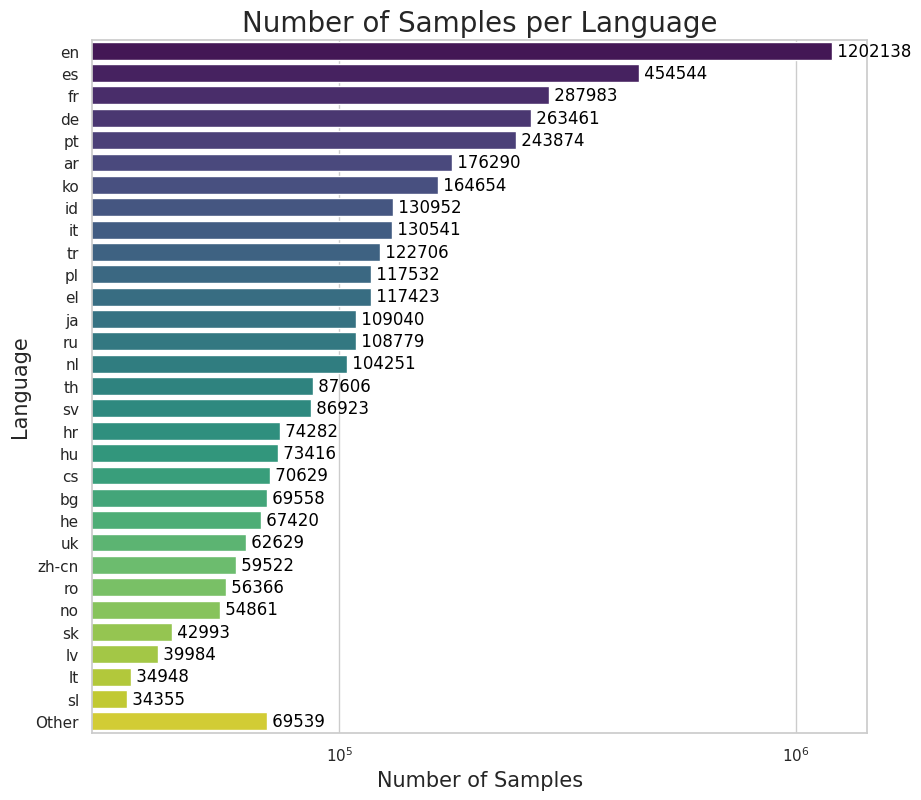

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

lang_dict = {}
rest = 0
for i, (k, v) in enumerate(lc.most_common()):
	if i < 30:
		lang_dict[k] = v
	else:
		rest += v
lang_dict['Other'] = rest

# Sample dictionary. Replace this with your actual data.
# lang_dict = dict(lc.most_common(20))

# Convert the dictionary into a DataFrame
df = pd.DataFrame(list(lang_dict.items()), columns=['Language', 'Count'])

# Sort the DataFrame by Count
# df = df.sort_values('Count', ascending=False)

# Create a bar plot
fg = plt.figure(figsize=(10, 9))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Count', y='Language', data=df, palette='viridis')

# Add labels and title
plt.xlabel('Number of Samples', fontsize=15)
plt.ylabel('Language', fontsize=15)
plt.title('Number of Samples per Language', fontsize=20)

# Annotate the bars with the actual counts
for index, value in enumerate(df['Count']):
    ax.text(value, index, f' {value}', color='black', va="center", fontsize=12)

plt.xscale('log');

# Show the plot
# plt.show()

In [190]:
# fg.savefig(root/'assets'/'lang-dist.png', bbox_inches='tight')

In [46]:
art

{'author': None,
 'title': 'Black Friday & Cyber Monday Playstation Deals (2021): PS4, PS5 & PlayStation Plus Deals Ranked by Save Bubble - Latest Digital Transformation Trends | Cloud News - Wire19',
 'description': 'Black Friday & Cyber Monday Playstation deals are underway, explore the best Black Friday & Cyber Monday PS4, PS4 and PS4 Pro sales listed below BOSTON–(BUSINESS WIRE)–Black Friday & Cyber Monday 2021 experts are identifying the best Playstation deals for Bla…',
 'url': 'https://wire19.com/black-friday-cyber-monday-playstation-deals-2021-ps4-ps5-playstation-plus-deals-ranked-by-save-bubble/',
 'urlToImage': 'https://mms.businesswire.com/media/20211127005163/en/835994/21/Black_Friday_2021_(SB).jpg',
 'publishedAt': '2021-11-27T21:34:52Z',
 'content': 'Black Friday &amp; Cyber Monday Playstation deals are underway, explore the best Black Friday &amp; Cyber Monday PS4, PS4 and PS4 Pro sales listed below\r\nBOSTON–(BUSINESS WIRE)–Black Friday &amp; Cyb… [+4598 chars]',
 'inst

In [51]:
# eg = [min(i['collectedAt'] for i in a['instances']) for a in articles[-100:]]
# len(eg)

In [173]:
from pandas import json_normalize

demo = articles[:10]

df = json_normalize(demo, sep='_', record_path='instances', meta=['author', 'title', 'description', 'url', 'urlToImage', 'publishedAt', 'content', 'source-id', 'source-name', 'langdetect'], record_prefix='instance_', )#errors='ignore')

In [174]:
df

,instance_collectedAt,instance_location,instance_category,author,title,description,url,urlToImage,publishedAt,content,source-id,source-name,langdetect
0,2020-08-07T18:53:00Z,ar,general,Mariana Leiva,"El dólar CCL y el MEP saltan hasta 2,6% y supe...",El dólar Contado con Liquidación avanza a $126...,https://www.ambito.com/finanzas/banco-central/...,https://media.ambito.com/adjuntos/239/imagenes...,2020-08-07T15:36:46Z,"El dólar MEP, o Bolsa -similar operación a la ...",None,ámbito.com,es
1,2020-08-07T18:53:00Z,ar,general,anónimo,"El “auto-test”, la metodología que eligió Rive...",Los futbolistas e integrantes del cuerpo técni...,https://www.infobae.com/deportes-2/2020/08/07/...,https://www.infobae.com/new-resizer/v5uL4x9H95...,2020-08-07T15:06:05Z,"Marcelo Gallardo, el primero en llegar para ha...",infobae,Infobae,es
2,2020-08-07T18:57:00Z,ar,sports,anónimo,"El “auto-test”, la metodología que eligió Rive...",Los futbolistas e integrantes del cuerpo técni...,https://www.infobae.com/deportes-2/2020/08/07/...,https://www.infobae.com/new-resizer/v5uL4x9H95...,2020-08-07T15:06:05Z,"Marcelo Gallardo, el primero en llegar para ha...",infobae,Infobae,es
3,2020-08-07T18:53:00Z,ar,general,Redacción LA NACION,"Muy cerca de Bradley Cooper, Jennifer Garner s...",,https://www.lanacion.com.ar/espectaculos/perso...,//bucket1.glanacion.com/anexos/fotos/10/334031...,2020-08-07T14:25:00Z,"Muy cerca de Bradley Cooper, Jennifer Garner s...",la-nacion,La Nacion,es
4,2020-08-07T18:57:00Z,ar,entertainment,Redacción LA NACION,"Muy cerca de Bradley Cooper, Jennifer Garner s...",,https://www.lanacion.com.ar/espectaculos/perso...,//bucket1.glanacion.com/anexos/fotos/10/334031...,2020-08-07T14:25:00Z,"Muy cerca de Bradley Cooper, Jennifer Garner s...",la-nacion,La Nacion,es
5,2020-08-07T18:53:00Z,ar,general,anónimo,"Habló Boris Prokoshev, el capitán del misterio...",Está retirado y vive en un pueblo aislado en R...,https://www.infobae.com/america/mundo/2020/08/...,https://www.infobae.com/new-resizer/Cuup7DggiJ...,2020-08-07T14:15:52Z,"Boris Prokoshev, el capitán del barco que llev...",infobae,Infobae,es
6,2020-08-07T18:53:00Z,ar,general,Delfina Torres Cabreros,Vuelos en septiembre. Frente a la indefinición...,,https://www.lanacion.com.ar/economia/negocios/...,//bucket1.glanacion.com/anexos/fotos/41/325554...,2020-08-07T14:15:00Z,"Algunas aerolíneas dan por sentado que, por la...",la-nacion,La Nacion,es
7,2020-08-07T18:53:00Z,ar,general,Nicolás Migliavacca,El destino de Abila si llega Romero a Boca - Olé,Riquelme y los suyos están cada vez más cerca ...,https://www.ole.com.ar/boca-juniors/boca-abila...,https://images.ole.com.ar/2020/08/07/lhye3rdbE...,2020-08-07T13:56:00Z,"Allá por el 2015, cuando todavía estaba en Méx...",None,Olé,es
8,2020-08-07T18:57:00Z,ar,sports,Nicolás Migliavacca,El destino de Abila si llega Romero a Boca - Olé,Riquelme y los suyos están cada vez más cerca ...,https://www.ole.com.ar/boca-juniors/boca-abila...,https://images.ole.com.ar/2020/08/07/lhye3rdbE...,2020-08-07T13:56:00Z,"Allá por el 2015, cuando todavía estaba en Méx...",None,Olé,es
9,2020-08-07T18:53:00Z,ar,general,Ismael Bermúdez,Jubilados: el aumento de septiembre será por d...,Mientras la Comisión Bicameral Mixta de Movili...,https://www.clarin.com/economia/economia/jubil...,https://images.clarin.com/2020/06/08/el-aument...,2020-08-07T13:55:34Z,Mientras la Comisión Bicameral Mixta de Movili...,None,Clarín,es


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

df = pd.DataFrame([ins for i in range(len(articles)) for ins in articles[i]['instances']])


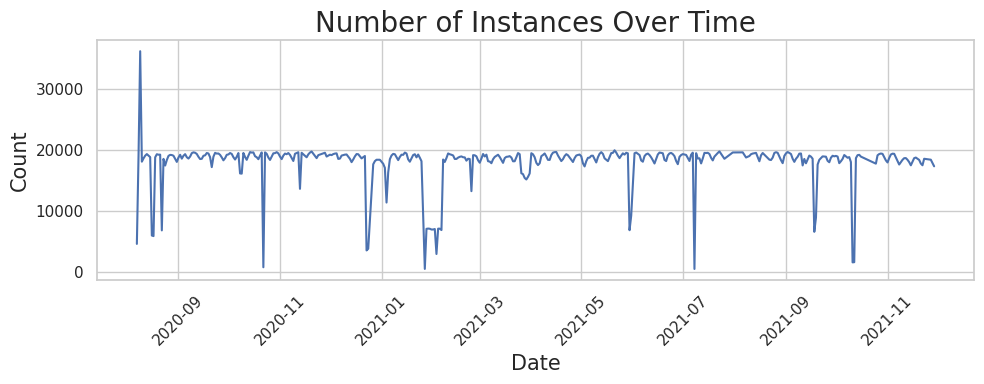

In [161]:

# Extracting the 'collectedAt' and 'category' fields and converting 'collectedAt' to datetime
df['date'] = pd.to_datetime(df['collectedAt'])
df['date'] = df['date'].dt.date  # Extracting just the date part

# Counting the number of samples per day per category
counts = df.groupby(['date', 'category']).size().reset_index(name='count')

# Pivoting the data to get categories as columns and dates as rows
pivot_counts = counts.pivot(index='date', columns='category', values='count').fillna(0)

# N = 3  # You can change this value as per your need
# pivot_counts = pivot_counts.iloc[N:]

# Plotting the data
fg = plt.figure(figsize=(10, 4))
# for category in pivot_counts.columns:
#     plt.plot(pivot_counts.index, pivot_counts[category], label=category)

totals = pivot_counts.sum(axis=1)
plt.plot(pivot_counts.index, totals)#, label='Total')

# Adding labels and legend
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Number of Instances Over Time', fontsize=20)
plt.xticks(rotation=45)
# plt.legend(title='Category')

# Display the plot
plt.tight_layout()
plt.grid(True)


In [162]:
# fg.savefig(root/'assets'/'total-counts.png', bbox_inches='tight');

In [68]:
# # Counting the number of samples per day per category
# counts = df.groupby(['date', 'location']).size().reset_index(name='count')
# 
# # Pivoting the data to get categories as columns and dates as rows
# pivot_counts = counts.pivot(index='date', columns='location', values='count').fillna(0)
# 
# # N = 3  # You can change this value as per your need
# # pivot_counts = pivot_counts.iloc[N:]
# 
# total_counts = pivot_counts.sum().sort_values(ascending=False)
# pivot_counts = pivot_counts[total_counts.index]
# 
# # Plotting the data
# plt.figure(figsize=(10, 6))
# for loc in pivot_counts.columns[:10]:
#     plt.plot(pivot_counts.index, pivot_counts[loc], label=loc)
# 
# # Adding labels and legend
# plt.xlabel('Date', fontsize=15)
# plt.ylabel('Count', fontsize=15)
# plt.title('Number of Samples per Location Over Time', fontsize=20)
# plt.xticks(rotation=45)
# plt.legend(title='Category')
# 
# # Display the plot
# plt.tight_layout()
# plt.grid(True)

In [92]:
pivot_table = pd.pivot_table(df, index='location', columns='category', aggfunc='size', fill_value=0)
sorted_columns = pivot_table.sum().sort_values(ascending=False).index
sorted_rows = pivot_table.sum(axis=1).sort_values(ascending=False).index
pivot_table = pivot_table.loc[sorted_rows, sorted_columns]

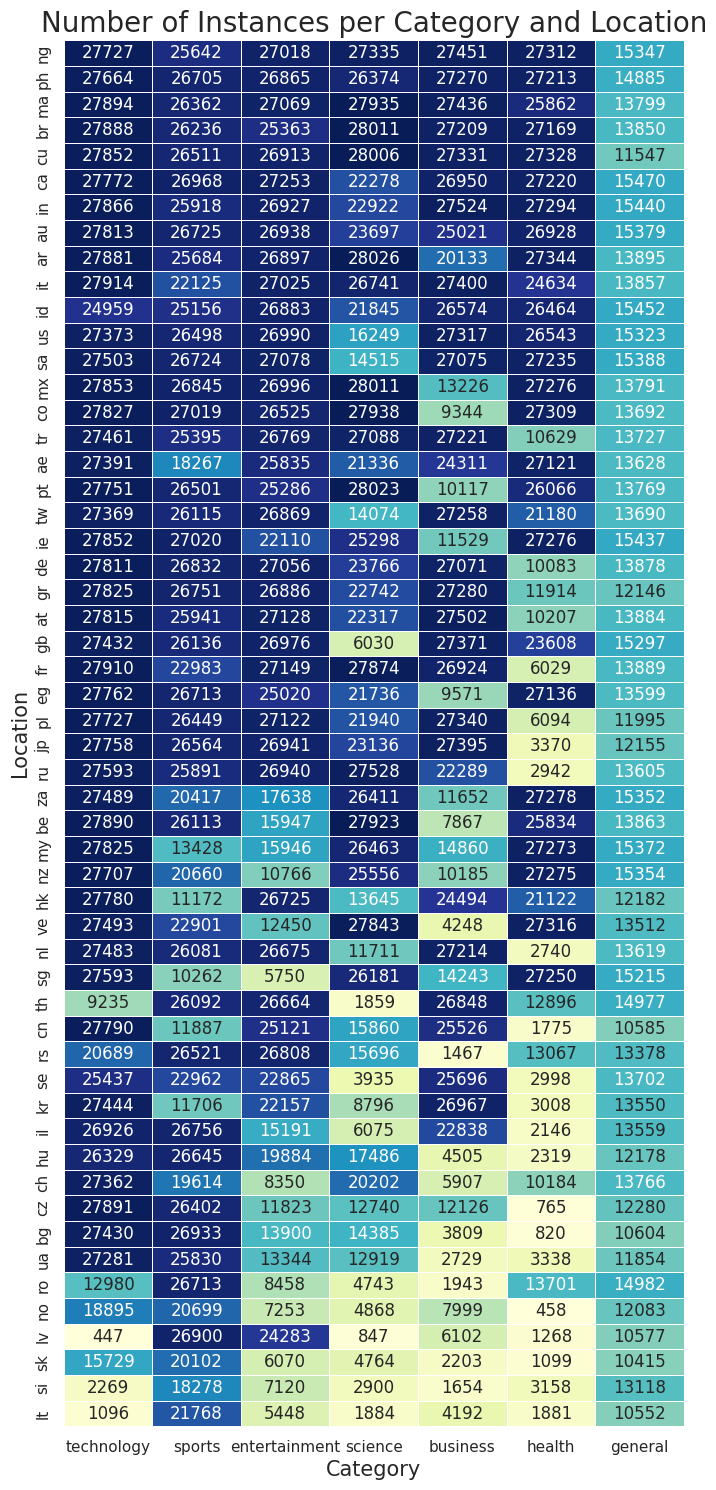

In [159]:
fg = plt.figure(figsize=(8, 18))
# plt.figure(figsize=(18, 8))

# Create a heatmap
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5, cbar=False)

# Add labels and title
plt.xlabel('Category', fontsize=15)
plt.ylabel('Location', fontsize=15)
plt.title('Number of Instances per Category and Location', fontsize=20);

# Show the plot
# plt.show()


In [160]:
# fg.savefig(root/'assets'/'loc-cat-mat.png', bbox_inches='tight');

In [90]:
country_counts = pivot_table.transpose().sum()
print(tabulate([(code, pycountry.countries.get(alpha_2=code.upper()).name.split(',')[0], count) 
				for code, count in country_counts.items()], headers=['Code', 'Name', 'Instances']))

Code    Name                    # Articles
------  --------------------  ------------
ng      Nigeria                     177832
ph      Philippines                 176976
ma      Morocco                     176357
br      Brazil                      175726
cu      Cuba                        175488
ca      Canada                      173911
in      India                       173891
au      Australia                   172501
ar      Argentina                   169860
it      Italy                       169696
id      Indonesia                   167333
us      United States               166293
sa      Saudi Arabia                165518
mx      Mexico                      163998
co      Colombia                    159654
tr      Turkey                      158290
ae      United Arab Emirates        157889
pt      Portugal                    157513
tw      Taiwan                      156555
ie      Ireland                     156522
de      Germany                     156497
gr      Gre

In [144]:
sources = [a['source-name'] for a in articles if a['source-name'] is not None]
freqs = Counter(sources)
len(sources) / len(articles)

1.0

In [157]:
print(tabulate(freqs.most_common(100), headers=['Source', 'Count']))

Source                       Count
-------------------------  -------
Google News                 195677
Yahoo Entertainment          63020
YouTube                      27062
Daily Mail                   25075
Infobae                      24658
Uol.com.br                   22374
Sapo.pt                      21358
Cnbeta.com                   20336
Yahoo.co.jp                  19224
Globo                        18391
Youm7.com                    17346
RT                           17093
BBC News                     16797
udn 聯合新聞網               15462
Ltn.com.tw                   15432
Sina.com.cn                  13853
Kompas.com                   13787
Stuff.co.nz                  13146
The Times of India           12701
Appledaily.com               12344
Detik.com                    11657
The Guardian                 11468
Chosun.com                   11400
Hindustan Times              11296
Aktuality.sk                 11061
Www.nu.nl                    10953
CNN                      

In [103]:
from wordcloud import WordCloud, STOPWORDS

In [125]:
# w, h = 1024, 576
# x, y = np.mgrid[:w, :h]
# x /= w
# y /= h

UFuncTypeError: Cannot cast ufunc 'divide' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [135]:
def create_mask(width, height):
    center_x, center_y = width // 2, height // 2
    radii_x, radii_y = center_x, center_y
    
    y, x = np.ogrid[:height, :width]
    mask = (x - center_x) ** 2 / radii_x ** 2 + (y - center_y) ** 2 / radii_y ** 2 > 1
    mask = 255 * mask.astype(int)
    
    return mask

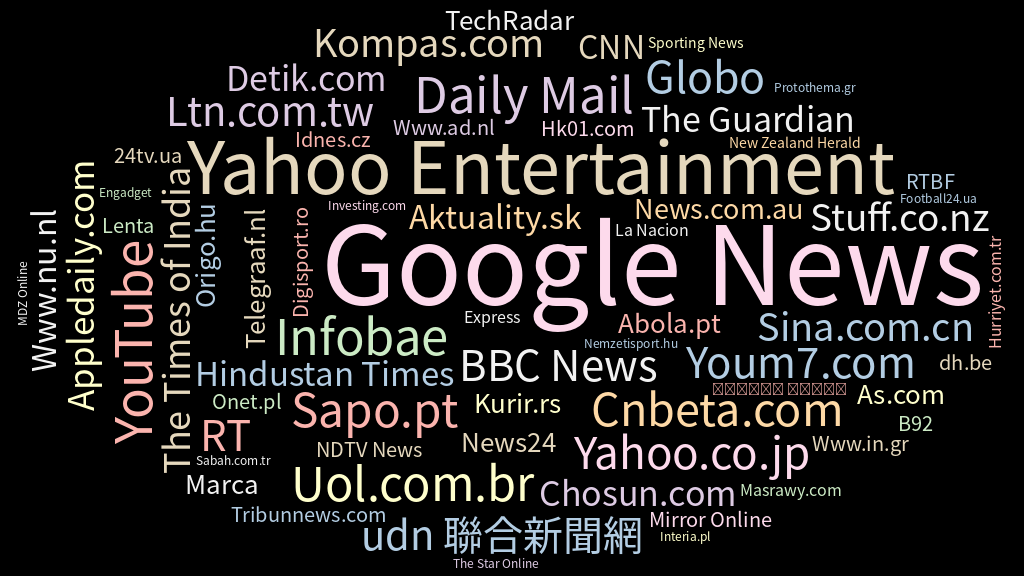

In [153]:
width, height = 1024, 576

wc = WordCloud(
	# width=width, height=height,
	mask=create_mask(width, height),
			   max_words=100, margin=10,
			   # font_path='/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf',
	font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc',
	# font_path='/usr/share/fonts/opentype/noto',
		                 min_font_size=10, background_color='black',
			   # mask=mask,
		                 colormap='Pastel1', 
			   stopwords=STOPWORDS, min_word_length=2,).generate_from_frequencies(freqs)
wc.to_image()

In [155]:
# wc.to_file(root/'assets'/'wordcloud.png');

In [165]:
first_seen = Counter([a['instances'][0]['location'] for a in articles])
print(tabulate(first_seen.most_common(100), headers=['Location', 'Count']))

Location      Count
----------  -------
br           135463
au           133481
id           131252
it           129005
ca           127445
in           123754
tr           122724
gr           119940
gb           119481
ar           119033
jp           118475
pl           116904
ru           113395
at           110272
cu           108769
pt           108365
ae           106094
nl           104031
ie           101041
fr           100561
ng            98976
tw            97008
de            96996
be            96124
us            92497
ma            91643
cn            91555
co            91184
th            90708
mx            89593
se            86838
kr            83090
hk            82324
rs            80040
ph            77055
hu            73509
eg            72760
cz            70647
my            68681
il            67794
bg            67223
ua            65610
za            63222
ro            54601
ch            52450
nz            52153
ve            47374
no            46804


In [179]:
# for i, a in enumerate(articles):
# 	a['ID'] = i

In [109]:
by_loc = {}
for a in tqdm(articles):
	loc = a['instances'][0]['location']
	by_loc.setdefault(loc, []).append(a)
len(by_loc)

  0%|          | 0/4719199 [00:00<?, ?it/s]

54

In [111]:
dat_dir = root / 'global-news-headlines'
dat_dir.mkdir(exist_ok=True)

In [114]:
for loc, arts in tqdm(by_loc.items()):
	save_json(arts, dat_dir / f'news-headlines-{loc}.json')

  0%|          | 0/54 [00:00<?, ?it/s]

In [178]:
too_long = {get_ident(a) for a in tqdm(articles) if len(a['title'].split(' - ')) > 2}
len(too_long)

  0%|          | 0/4719199 [00:00<?, ?it/s]

426996

In [87]:
# country_counts = pivot_table.transpose().sum()

In [88]:
# for code, count in country_counts.items():
# 	# country = pycountry.countries.get(alpha_2=code.upper())
# 	# print(country.name, count)
# 	print(code, count)
# 	

AttributeError: 'Series' object has no attribute 'rows'

In [ ]:


# Your text string
text = "Bonjour tout le monde"

# Detect the language
language = detect(text)

print(f"The language is: {language}")


In [58]:
xs = unique[bad[0]]

In [59]:
diffs = [article_difference(a, xs[0]) for a in xs[1:]]

In [ ]:
path = random.choice(recs)
path = random.choice(list(root.glob('**/general_us.json')))
path

In [ ]:
content = load_json(path)
content.keys()

In [56]:
art = content['articles'][0]#.keys()
art.keys()

dict_keys(['source', 'author', 'title', 'description', 'url', 'urlToImage', 'publishedAt', 'content'])

In [57]:
art['publishedAt']

'2020-10-31T06:40:27Z'

In [52]:
*rest, scrape_date, scrape_time, _ = path.parts
scraped = parse_date(scrape_date, scrape_time).strftime('%Y-%m-%dT%H:%M:%SZ')
cat, loc = path.stem.split('_')
cat, loc, scraped

('general', 'hk', '2021-03-31T07:59:00Z')

In [8]:
full = {}

In [9]:
itr = tqdm(sorted(recs))
for p in itr:
	*rest, scrape_date, scrape_time, _ = p.parts
	if scrape_date.startswith('bad'):
		continue
	scraped = parse_date(scrape_date, scrape_time).strftime('%Y-%m-%dT%H:%M:%SZ')
	cat, loc = p.stem.split('_')
	if cat not in cats:
		if loc not in cats:
			raise ValueError(f'Unknown category {cat} {loc}')
		cat, loc = loc, cat
	content = load_json(p)
	# itr.set_description(f'{len(content["articles"])} {cat}-{loc}')
	for a in content['articles']:
		a.update({'location': loc, 'category': cat, 'collectedAt': scraped})
		full.setdefault(loc, {}).setdefault(cat, []).append(a)
len(full)	

  0%|          | 0/152506 [00:00<?, ?it/s]

54

In [10]:
sec = full['us']

In [11]:
len(sec['general'])

15323

In [12]:
base_raw = [a['title'] for arts in [sec['business'], sec['entertainment'], sec['health'], 
									sec['science'], sec['sports'], sec['technology']] 
			for a in arts]
base = Counter(base_raw)
len(base_raw), len(base)

(150972, 137569)

In [13]:
print(tabulate(base.most_common(10), headers=['Title', 'Count']))

Title                                                                                                    Count
-----------------------------------------------------------------------------------------------------  -------
Covid-19 vaccine tracker: View vaccinations by country - CNN                                                20
The latest on the coronavirus pandemic and vaccines: Live updates - CNN                                     18
Volcanoes Today - summary of volcanic activity world-wide - VolcanoDiscovery                                18
The latest on the coronavirus pandemic: Live updates - CNN                                                  14
Updated daily: Latest COVID-19 cases, deaths in Ohio, Kentucky, Indiana - WLWT Cincinnati                   12
Coronavirus Map: Tracking COVID-19 cases across the Bay Area and California - San Francisco Chronicle       11
Space calendar 2021: Rocket launches, sky events, missions & more! - Space.com                              11
B

In [35]:
key = base.most_common(1)[0][0]
res = [a for arts in sec.values() for a in arts if a['title'] == key]
len(res)

20

In [37]:
novel = [a['title'] for a in sec['general'] if a['title'] not in base]
len(novel)/len(sec['general'])

0.4091235397768061

In [15]:
titles = {}
for c, arts in sec.items():
	for a in arts:
		titles.setdefault(a['title'], set()).add(a['category'])

general:   0%|          | 0/15323 [00:00<?, ?it/s]

business:   0%|          | 0/27317 [00:00<?, ?it/s]

entertainment:   0%|          | 0/26990 [00:00<?, ?it/s]

health:   0%|          | 0/26543 [00:00<?, ?it/s]

science:   0%|          | 0/16251 [00:00<?, ?it/s]

sports:   0%|          | 0/26498 [00:00<?, ?it/s]

technology:   0%|          | 0/27373 [00:00<?, ?it/s]

In [16]:
for v in titles.values():
	v.discard('general')

In [17]:
multis = {k: v for k, v in titles.items() if len(v) > 1}

In [23]:


country_names = {}

for code in codes:
    try:
        country = pycountry.countries.get(alpha_2=code.upper())
        country_names[code] = country.name
    except AttributeError:
        country_names[code] = None

print(country_names)


{'lt': 'Lithuania', 'ie': 'Ireland', 'cn': 'China', 'us': 'United States', 'my': 'Malaysia', 'ma': 'Morocco', 'se': 'Sweden', 'nl': 'Netherlands', 'il': 'Israel', 'ch': 'Switzerland', 'rs': 'Serbia', 'ng': 'Nigeria', 've': 'Venezuela, Bolivarian Republic of', 'si': 'Slovenia', 'lv': 'Latvia', 'jp': 'Japan', 'ph': 'Philippines', 'hu': 'Hungary', 'it': 'Italy', 'cz': 'Czechia', 'bg': 'Bulgaria', 'mx': 'Mexico', 'gr': 'Greece', 'co': 'Colombia', 'gb': 'United Kingdom', 'cu': 'Cuba', 'in': 'India', 'sa': 'Saudi Arabia', 'hk': 'Hong Kong', 'sk': 'Slovakia', 'kr': 'Korea, Republic of', 'id': 'Indonesia', 'au': 'Australia', 'fr': 'France', 'ca': 'Canada', 'ua': 'Ukraine', 'th': 'Thailand', 'ru': 'Russian Federation', 'pl': 'Poland', 'tr': 'Turkey', 'pt': 'Portugal', 'be': 'Belgium', 'eg': 'Egypt', 'ae': 'United Arab Emirates', 'no': 'Norway', 'za': 'South Africa', 'br': 'Brazil', 'at': 'Austria', 'ro': 'Romania', 'ar': 'Argentina', 'de': 'Germany', 'tw': 'Taiwan, Province of China', 'nz': 'Ne

In [43]:
country_names['tr']

'Turkey'